In [3]:
import nltk
import spacy
import gensim
import numpy as np
import pandas as pd
import os
import networkx as nx
from gensim import corpora
from gensim import models
from collections import defaultdict
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

## Fine-tunning module

In [8]:
from spacy.tokens.doc import Doc
nlp = spacy.load("en_core_web_sm")

def find_nouns(document):
    doc = nlp(document)
    noun_words =[]
    for token in doc:
        if token.pos_ == "NOUN":
            noun_words.append(token.text)
    return noun_words

def find_tfidf(processed_data):
    text = processed_data
    doc_set = [doc.strip() for doc in text.split('\n')]
    texts = [[word for word in doc.lower().split()] for doc in doc_set]
    dictionary = corpora.Dictionary(texts)
    doc_term_matrix = [dictionary.doc2bow(text) for text in texts]
    tfidf = models.TfidfModel(doc_term_matrix)

    df_dict = defaultdict(int)
    for doc in doc_term_matrix:
        for id, freq in doc:
            df_dict[id] += 1

    tfidf_dict = {}
    for id, value in tfidf[dictionary.doc2bow(text.lower().split())]:
        tfidf_dict[dictionary[id]] = value * df_dict[id]

    mean_tfidf = sum(tfidf_dict.values()) / len(tfidf_dict)
    important_words = [word for word in tfidf_dict if tfidf_dict[word] > mean_tfidf]

    return important_words

def find_concept_words(important_words,nouns):
    important_concepts = [word for word in important_words if word in nouns]
    return important_concepts


def co_occurences(text):
    sentences = [doc.strip() for doc in text.split('\n')]
    vocab = set(word_tokenize(text,language="english"))
    token_sent_list = [word_tokenize(sen,language="english") for sen in sentences]
    co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
    k=2

    for sen in token_sent_list:
        for ii in range(len(sen)):
            if ii < k:
                c = Counter(sen[0:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            elif ii > len(sen)-(k+1):
                c = Counter(sen[ii-k::])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            else:
                c = Counter(sen[ii-k:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c

# Having final matrix in dict form 
    co_occ = {ii:dict(co_occ[ii]) for ii in vocab}
    return co_occ

def find_communities(co_occ):
    G = nx.Graph()
    G.add_nodes_from(important_concepts)
    for word1 in important_concepts:
        if word1 in co_occ:
            for word2, weight in co_occ[word1].items():
                if word2 in important_concepts and weight >= 3:
                    G.add_edge(word1, word2, weight=weight)
   # nx.draw(G,with_labels=True,node_color ='r')

    communities = nx.community.girvan_newman(G)
    good_communities =[]
    for c in next(communities):
        if len(c)>3:
            good_communities.append(c)
    return good_communities

    


## Fine-tune Document-1

In [14]:
corpus = pd.read_csv('alldoc_processed.csv')
doc1 = corpus['text2'][10]
doc1_p = corpus['text'][10]

noun_words = find_nouns(doc1)
important_words = find_tfidf(doc1)
important_concepts = find_concept_words(important_words,noun_words)

co_occ = co_occurences(doc1_p)
good_communities1 = find_communities(co_occ)


In [15]:
for c in good_communities1:
    print(c,type(c))

{'son', 'plaintiff', 'access', 'law', 'begotten', 'marriage', 'mother', 'paternity', 'time'} <class 'set'>
{'case', 'husband', 'hindu', 'father', 'question', 'purposes', 'gift', 'wife', 'deed', 'favour'} <class 'set'>
{'property', 'daughter', 'gifts', 'share', 'family', 'properties', 'half'} <class 'set'>


## Fine-tune Document-2

In [21]:
doc2 = corpus['text2'][20]
doc2_p = corpus['text'][20]

noun_words = find_nouns(doc2)
important_words = find_tfidf(doc2)
important_concepts = find_concept_words(important_words,noun_words)

co_occ = co_occurences(doc2_p)
good_communities2 = find_communities(co_occ)

In [22]:
for c in good_communities2:
    print(c,type(c))

{'completion', 'period', 'question', 'tenant', 'possession', 'construction', 'exemption', 'years', 'date', 'building'} <class 'set'>
{'rent', 'grounds', 'section', 'act', 'institution', 'eviction', 'judge', 'restriction', 'sub', 'suit', 'control', 'operation'} <class 'set'>


## Fine-tune Document-3

In [23]:
corpus = pd.read_csv('alldoc_processed.csv')
doc3 = corpus['text2'][0]
doc3_p = corpus['text'][0]

noun_words = find_nouns(doc3)
important_words = find_tfidf(doc3)
important_concepts = find_concept_words(important_words,noun_words)

co_occ = co_occurences(doc3_p)
good_communities3 = find_communities(co_occ)

for c in good_communities3:
    print(c,type(c))

{'provisions', 'section', 'sub', 'clause', 'date', 'agra', 'proceedings', 'use', 'furnish', 'evidence', 'force', 'thereunder', 'commencement', 'rules', 'compliance', 'particulars', 'accordance', 'act', 'amendment', 'suits', 'proviso'} <class 'set'>
{'air', 'revenue', 'sir', 'board', 'acres', 'provinces', 'rights', 'tenant', 'rupees', 'ejectment', 'holders', 'khudkasht', 'rate', 'land', 'suit', 'holder'} <class 'set'>


## Vectorizing and finding cosine-similarity

In [25]:
w2v = pd.read_csv('tfidf_weighted_word_vectors.csv',index_col=0)
vector_document1 =[]
vector_document2 =[]
vector_document3 =[]

for c1 in good_communities1:
    n = len(c1)
    v = np.zeros(shape=(200))
    for val in c1:
        v += w2v.loc[val,:].to_numpy()
    vector_document1.append(v/n)

for c2 in good_communities2:
    n = len(c2)
    v = np.zeros(shape=(200))
    for val in c2:
        v += w2v.loc[val,:].to_numpy()
    vector_document2.append(v/n)

for c3 in good_communities3:
    n = len(c3)
    v = np.zeros(shape=(200))
    for val in c3:
        v += w2v.loc[val,:].to_numpy()
    vector_document3.append(v/n)


    

## Finding Similarity between Doc-1 and Doc-3

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
m = len(vector_document1)
n = len(vector_document3)
# create a mxn matrix to store the cosine similarity values
cos_sim_matrix1 = [[0 for j in range(n)] for i in range(m)]

# compute the cosine similarity between each pair of vectors in the two lists
for i in range(m):
    for j in range(n):
        cos_sim_matrix1[i][j] = cosine_similarity([vector_document1[i]], [vector_document3[j]])[0][0]



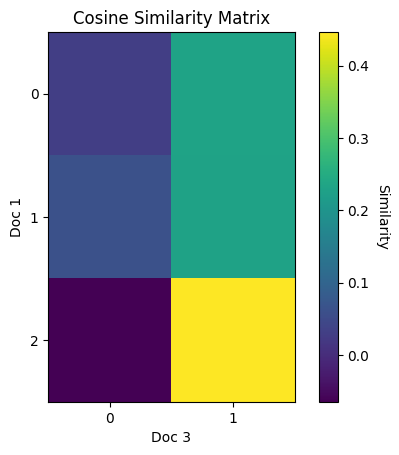

In [28]:

import matplotlib.pyplot as plt
import numpy as np

# assume you have already computed the cosine similarity matrix as a mxn numpy array

# create a heatmap of the cosine similarity matrix
fig, ax = plt.subplots()
im = ax.imshow(cos_sim_matrix1)

# set the tick labels for the x and y axes
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels([str(i) for i in range(n)])
ax.set_yticklabels([str(i) for i in range(m)])

# set the axis labels and title
ax.set_xlabel('Doc 3')
ax.set_ylabel('Doc 1')
ax.set_title('Cosine Similarity Matrix')

# add a colorbar to show the correspondence between the color scale and the similarity values
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Similarity', rotation=-90, va='bottom')

# display the heatmap
plt.show()



## Finding similarity of Doc-2 and Doc-3

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
m = len(vector_document2)
n = len(vector_document3)
# create a mxn matrix to store the cosine similarity values
cos_sim_matrix2 = [[0 for j in range(n)] for i in range(m)]

# compute the cosine similarity between each pair of vectors in the two lists
for i in range(m):
    for j in range(n):
        cos_sim_matrix2[i][j] = cosine_similarity([vector_document2[i]], [vector_document3[j]])[0][0]



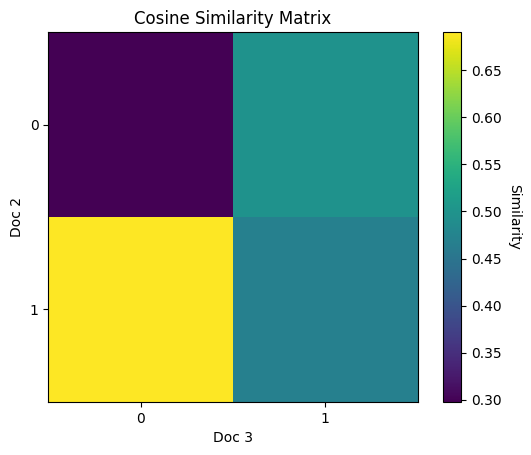

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# assume you have already computed the cosine similarity matrix as a mxn numpy array

# create a heatmap of the cosine similarity matrix
fig, ax = plt.subplots()
im = ax.imshow(cos_sim_matrix2)

# set the tick labels for the x and y axes
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels([str(i) for i in range(n)])
ax.set_yticklabels([str(i) for i in range(m)])

# set the axis labels and title
ax.set_xlabel('Doc 3')
ax.set_ylabel('Doc 2')
ax.set_title('Cosine Similarity Matrix')

# add a colorbar to show the correspondence between the color scale and the similarity values
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Similarity', rotation=-90, va='bottom')

# display the heatmap
plt.show()

